<a href="https://colab.research.google.com/github/Agoroschuk/RAG/blob/main/tourist_rag_no_outputs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h3 style="text-align: center;"><b>RAG-система для туристического помощника </b></h3>

**Работа состоит из 3 основных частей:**

1. Предобработка и очистка текстовых данных, удаление выбросов с использованием изображений

2. Создание RAG-системы туристического помощника, позволяющего ответить на вопросы о путешествиях по городам России (Екатеринбург, Владимир, Ярославль, Нижний Новгород)

3. Оценка RAG-системы с помощью RAGAS-метрик


Дан набор данных, содержащий информацию о памятниках, архитектуре и других значимых местах. В данных есть:
* название достопримечательности;
* идентификатор на WikiData;
* город расположения;
* координаты долготы и широты;
* описание (извлеченное из WikiData);
* изображение в формате base64;
* сгенерированное описание изображения (генерация с помощью модели BLIP).

Некоторые из памятников могут встречаться несколько раз, но с различными изображениями, из которых не все могут быть качественными. Для компенсации этого даны текстовые описания.

In [ ]:
!pip install -q gdown torch transformers transformers accelerate bitsandbytes langchain sentence-transformers openpyxl datasets langchain-community ragatouille umap-learn ragatouille

In [ ]:
!pip install -U -q langchain-community git+https://github.com/stanford-futuredata/ColBERT.git

In [ ]:
import gdown
import pandas as pd
from tqdm import tqdm
from typing import Optional, List, Tuple
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from langchain.docstore.document import Document as LangchainDocument
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer
from langchain.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores.utils import DistanceStrategy
import numpy as np
import plotly.express as px
from transformers import pipeline
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from ragatouille import RAGPretrainedModel

import base64
import requests
import matplotlib.pyplot as plt
from PIL import Image
import PIL
from io import BytesIO
import nltk
nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize

In [ ]:
!pip install nbformat -U -q

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## 1. Загрузка данных и EDA

In [ ]:
url = 'https://drive.google.com/uc?id=1P1BsvI2jPN3fEqjc2YZxmQ-MTs22WVUk'
output = 'file.csv'

gdown.download(url, output, quiet=False)

data = pd.read_csv('file.csv', index_col=0).reset_index(drop=True)

In [ ]:
# Как устроены данные
data.head()

In [ ]:
# Всего 14634 изображения с описаниями
data.info()

Код для декодирования изображений, закодированных в формате base64:

In [ ]:
def get_image(data):
  """
  Принимает строку с image и выводит изображение
  """
  image = Image.open(BytesIO(base64.b64decode(data))).convert('RGB')
  return image

get_image(data.sample(1)['image'].tolist()[0])

In [ ]:
def get_image_with_description(data, index=None):
    """
    Выводит изображение и его описание из DataFrame.

    Параметры:
        data (pd.DataFrame): DataFrame с колонками 'image' и 'en_txt'.
        index (int, optional): Индекс строки. Если None — берёт случайную строку.
    """
    if index is None:
        row = data.sample(1).iloc[0]
    else:
        row = data.iloc[index]

    image = Image.open(BytesIO(base64.b64decode(row['image']))).convert('RGB')

    print("Описание BLIP:", row['en_txt'], '\n', '\nОписание WikiData', row['description'])

    return image

get_image_with_description(data)

**Подход для очистки данных**

1. Использовать подход с tf-idf для удаления мусорных изображений. Для этого отсортируем английские слова в 'en_txt' по суммарному tf-df. Из-за модифицированной сглаженной версии расчета tf-idf в sklearn и суммирования tf-idf по строкам, где строка = каждый объект в данных, получаем, что слова из 'en_txt', встречающиеся почти в каждом документе, будут иметь высокий tf-idf.

2. Выделим редкие слова (низкий tf-idf) и удалим объекты, в описании которых они присутствуют

3. Сгруппируем оставшиеся объекты датасета, объединим описание

4. В итоге получим 325 объектов датасета, очищенных от выбросов

In [ ]:
# Распределение числа символов в description, en_text

plt.figure(figsize=(12, 5))
plt.suptitle('Распределение числа символов в description, en_text', fontsize=14, y=1.05)

plt.subplot(1, 2, 1)
plt.hist(data['description'].str.len(), bins=30, color='blue')
plt.title('Количество символов в description')
plt.xlabel('Число символов')

plt.subplot(1, 2, 2)
plt.hist(data['en_txt'].str.len(), bins=30, color='coral')
plt.title('Количество символов в en_txt')
plt.xlabel('Число символов')

plt.tight_layout()
plt.show()

In [ ]:
# Распределение числа токенов после nltk токенизации в description, en_text

plt.figure(figsize=(12, 5))
plt.suptitle('Распределение числа токенов (слов) в текстах', fontsize=14, y=1.05)

plt.subplot(1, 2, 1)
plt.hist(data['description'].apply(lambda x: len(word_tokenize(str(x)))), bins=30, color='skyblue')
plt.title('Количество слов в description')
plt.xlabel('Число слов')

plt.subplot(1, 2, 2)
plt.hist(data['en_txt'].apply(lambda x: len(word_tokenize(str(x)))), bins=30, color='salmon')
plt.title('Количество слов в en_txt')
plt.xlabel('Число слов')

plt.tight_layout()
plt.show()

**Для расчета** TF-IDF выбран 'en_txt', т.к. более длинный и содержательный столбец для выявления выбрсоов

**Как рассчитывается tf-idf в sklearn**

\begin{equation}
\text{tf-idf}(t,d) = \text{tf}(t,d) \times (\text{idf}(t) + 1)
\end{equation}

где:

TF (Term Frequency):
\begin{equation}
\text{tf}(t,d) = \frac{\text{число вхождений } t \text{ в } d}{\text{общее число слов в } d}
\end{equation}

IDF (Inverse Document Frequency):
\begin{equation}
\text{idf}(t) = \log\left(\frac{1 + n}{1 + \text{df}(t)}\right) + 1
\end{equation}

In [ ]:
# 14634 документа с описанием, 1824 уникальных слова на английском
vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(data['en_txt'])
print('Форма матрицы tf-idf', vectors.shape)

# Просуммируем tf-idf слов по всем документам
word_frequency = pd.DataFrame(
    vectors.sum(axis=0).T,
    index=vectorizer.get_feature_names_out(),
    columns=['frequency']
)
word_frequency[:5]

In [ ]:
# Посмотрим примеры слов с низким tf-idf
def show_rare_words(
    word_freq_df,
    threshold=0.5,
    title="Low-Frequency Words (tf-idf < {threshold})",
    figsize=(40, 18),
    palette="viridis",
    annotate=False,
    rotation=45,
    legend=False
):
    """
    Показывает примеры редких слов с суммарным tf-idf ниже заданного порога.
    """
    rare_words = (
        word_freq_df[word_freq_df['frequency'] < threshold]
        .sort_values('frequency', ascending=True)
    )

    sns.set_style("whitegrid")
    plt.figure(figsize=figsize)

    ax = sns.barplot(
        x=rare_words.index,
        y='frequency',
        data=rare_words,
        palette=palette,
        hue=rare_words['frequency'],
        dodge=False
    )

    plt.title(
        title.format(threshold=threshold),
        fontsize=30,
        pad=20
    )
    plt.xlabel("Words", fontsize=18)
    plt.ylabel("Frequency", fontsize=18)
    plt.xticks(rotation=rotation, ha='right')


    plt.tight_layout()
    plt.show()

show_rare_words(word_frequency, threshold=0.5)

In [ ]:
# Посмотрим на выбросы, сгруппированные по слову

for word in word_frequency[word_frequency['frequency'] < 0.5]\
                .sort_values(by='frequency', ascending=True).index[:5]:
    plt.figure(figsize=(20, 2.5))
    plt.suptitle(word)
    for i, img in enumerate(data[(data['en_txt'].str.contains(word))].head(10).index):
        plt.subplot(1, 10, i+1)
        plt.imshow(get_image(data.iloc[img]['image']))
    plt.show()

**Вывод**: стоит исключить объекты, в описании которых присутствуют слова с tf-idf < 0.5. Порог выбран эмпирически

In [ ]:
# Исключим с помощью регулярных выражений строки с редкими словами
data_to_drop = data[
    (data['en_txt'].str.contains('|'.join(word_frequency[word_frequency['frequency'] < 0.5].sort_values(by='frequency', ascending=True).index)))
    & (~data['en_txt'].str.contains('building|pane'))
].index

cleaned_data = data[~data.index.isin(data_to_drop) & ~data['en_txt'].isna() & ~data['WikiData'].isna()][['Name', 'WikiData', 'City', 'Lon', 'Lat', 'description', 'image', 'en_txt']]
len(cleaned_data)

In [ ]:
cleaned_data.info()

In [ ]:
def show_unique_counts(data):
    print('Всего объектов в датасете: ', data.shape[0])
    print('Число уникальных Name:', data['Name'].nunique())
    print('Число уникальных WikiData id:', data['WikiData'].nunique())
    print('Число уникальных City:', data['City'].nunique())
    print('Число пар значений долготы и широты :', data[['Lon', 'Lat']].shape[0])
    print('Число уникальных пар значений долготы и широты :', data[['Lon', 'Lat']].drop_duplicates().shape[0])
    print('Число уникальных WikiData description:', data['description'].nunique())
    print('Число уникальных image:', data['image'].nunique())
    print('Число уникальных описаний en_txt:', data['en_txt'].nunique())

show_unique_counts(cleaned_data)

In [ ]:
data.head(1)

In [ ]:
# Объединение описания для одинаковых объектов с помощью двойного переноса строки

pd.set_option('display.max_colwidth', None)
cleaned_data['text'] = cleaned_data.groupby(['Name', 'WikiData', 'City', 'Lon', 'Lat', 'description'])['en_txt']\
                                  .transform(lambda x: '\n\n'.join(x))
# Уберем дублирующиеся строки
grouped_data = cleaned_data[['Name', 'WikiData', 'City', 'Lon', 'Lat', 'description', 'text']]\
                      .drop_duplicates().reset_index(drop=True)

print('Объектов в датасете до объединения:', len(cleaned_data))
print('Объектов в датасете после объединения:', len(grouped_data))

grouped_data[['City', 'Name', 'text']].head(1)

**Далее для поиска непохожих друг на друга предложений**, характеризующих локацию с разных сторон, используется метрика качества машинного перевода BLEU. Все пары предложений перебираются и считаются достаточно различными, если BLEU-score < 0.35. Значение порога выбрано эмпирически

**Метрика BLEU вычисляется по следующей формуле:**

\begin{equation}
BLEU = BP \cdot \exp\left(\sum_{n=1}^{N} w_n \log p_n\right)
\end{equation}

где:
- $BP$ --- штраф за краткость (Brevity Penalty),
- $p_n$ --- точность для $n$-грамм (1-граммы, 2-граммы и т.д.),
- $w_n = \frac{1}{N}$ --- веса для $n$-грамм (по умолчанию),
- $N = 4$ --- максимальный порядок $n$-грамм.

Компоненты формулы

**Модифицированная точность n-грамм**
\begin{equation}
p_n = \frac{\sum_{\text{кандидат}} \text{Count}_{\text{clip}}(n\text{-грамма})}{\sum_{\text{кандидат}} \text{Count}(n\text{-грамма})}
\end{equation}

где:
- $\text{Count}_{\text{clip}}$ --- ограниченное количество вхождений $n$-граммы (не больше максимального количества в любом эталоне),
- $\text{Count}$ --- общее количество $n$-грамм в кандидате.

**Штраф за краткость (Brevity Penalty)**
\begin{equation}
BP =
\begin{cases}
1 & \text{если } c > r, \\
e^{1 - r/c} & \text{если } c \le r,
\end{cases}
\end{equation}

где:
- $c$ --- длина кандидата (количество слов),
- $r$ --- эффективная длина эталона (ближайшая к $c$ среди всех эталонов).

In [ ]:
# Для каждого объекта проанализируем каждую пару из предложений в text с помошью BLEU
# чтобы оставить только самые уникальные пары, сделать описание разнообразным

tfidf_tokenizer = vectorizer.build_tokenizer()

def filter_text(row):
    """

    """
    city = row['City']
    name = row['Name']
    raw_texts = row['text'].split('\n\n')

    candidates = set()
    high_bleu = set()

    # Сравниваем все пары предложений
    for sentence in raw_texts:
        for hypothesis in raw_texts:
            if sentence == hypothesis:
                continue

            tokenized_sentence = tfidf_tokenizer(sentence)
            tokenized_hypothesis = tfidf_tokenizer(hypothesis)

            bleu_score = nltk.translate.bleu_score.sentence_bleu(
                [tokenized_sentence],
                tokenized_hypothesis
            )

            if bleu_score < 0.35:
                candidates.add(hypothesis)
            else:
                high_bleu.add(hypothesis)

    unique_texts = candidates - high_bleu
    return '\n\n'.join([f"{city} {name}  {text}" for text in unique_texts])

# Применяем функцию к каждой строке датафрейма
grouped_data['processed_text'] = grouped_data[['City', 'Name', 'text']].apply(filter_text, axis=1)

In [ ]:
def visualize_sentences(df):
    text_dict = {}

    for text in df:
        if isinstance(text, str):
            lines = text.split('\n\n')
            for line in lines:
                if line.strip():
                    text_dict[line.strip()] = text_dict.get(line.strip(), 0) + 1

    print("Количество уникальных строк:", len(text_dict))
    for line, count in list(text_dict.items()):
        print(f"{count}: {line}")

In [ ]:
# Для примера, насколько сократилось описание объекта
visualize_sentences(grouped_data['text'].head(1))

In [ ]:
# Для примера, насколько сократилось описание объекта
visualize_sentences(grouped_data['processed_text'].head(1))

In [ ]:
# Данные после очистки от выбросов
grouped_data.info()

In [ ]:
grouped_data.head(1)

In [ ]:
# рассмотрим распределение пар Name-City
def cities_names_distribution(data):
    pair_counts = data.groupby(['Name', 'City']).size().reset_index(name='count')

    fig = px.bar(
        pair_counts,
        y='count',
        title='Гистограмма уникальных пар Name-City',
        labels={'x': 'Пары name-city', 'y': 'Количество вхождений'},
        hover_data={'Name': True, 'City': True},
    )

    fig.update_layout(
        xaxis_title="Пары Name-City",
        yaxis_title="Количество вхождений"
    )

    fig.show()

In [ ]:
# Распределение до очистки от выбросов и группировки
cities_names_distribution(data)

In [ ]:
# Получили практически равномерное распределение пар
cities_names_distribution(grouped_data)

**Выводы по EDA**:

1. По словам с низким tf-idf данные удалось очистить от  от совсем выбросов, выбросы перед очисткой продетектированы визуально

2. Данные сгруппированы по 'Name', 'WikiData', 'City', 'Lon', 'Lat', 'description', 'text' для выделения одинаковых объектов. Для сгрупированных объектов объединено описание 'en_txt'

3. Из описания 'en_txt' уникальных объектов удалены похожие по содержанию описания с помощью метрики BLEU качества оценки машинного перевода. Оставлены лишь те пары предложений, для которых BLEU < определенного порога

4. Получено 325 объекта, равномерно распределенных географически по Name-City


# 2. RAG

![](https://huggingface.co/datasets/huggingface/cookbook-images/resolve/main/RAG_workflow.png)

#### Ретривер

**Компоненты**:
1. Text Splitter = CharacterTextSplitter

Модели будут мультиязычными с поддержкой русского и английского языка
2. EMBEDDING_MODEL_NAME = "intfloat/multilingual-e5-large"
3. READER_MODEL_NAME ="teknium/OpenHermes-2.5-Mistral-7B" квантизованная
4. RERANKER = "colbert-ir/colbertv2.0"
5. KNOWLEDGE_DATABASE = FAISS

In [ ]:
!pip install -U -q langchain-community

In [ ]:
from langchain.docstore.document import Document as LangchainDocument
from typing import List, Optional
from langchain_core.documents import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter
from transformers import AutoTokenizer
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer, AutoModel
from langchain.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores.utils import DistanceStrategy
import pickle
from google.colab import drive
import numpy as np
import pandas as pd
import plotly.express as px
from sklearn.decomposition import PCA
from umap import UMAP
import gc

In [ ]:
EMBEDDING_MODEL_NAME = 'intfloat/multilingual-e5-large'

In [ ]:
# Посмотрим на примеры токенов в эмбеддере
model = AutoModel.from_pretrained(EMBEDDING_MODEL_NAME)
tokenizer = AutoTokenizer.from_pretrained(EMBEDDING_MODEL_NAME)

text = "Пример текста на русском и english."
tokens = tokenizer.tokenize(text)

print(f"Примеры токенов: {tokens}")
print(f"Количество токенов: {len(tokens)}")
print(f"max_seq_length модели: {tokenizer.model_max_length}")

In [ ]:
RAW_KNOWLEDGE_BASE = [
    LangchainDocument(
        page_content=row["processed_text"],
        metadata={"source": row["WikiData"]}
    )
    for _, row in tqdm(grouped_data.iterrows(), total=len(grouped_data))
]

In [ ]:
def additional_split_documents(
    chunk_size: int,
    knowledge_base: List[LangchainDocument],
    tokenizer_name: Optional[str] = EMBEDDING_MODEL_NAME,
) -> List[LangchainDocument]:
    """
    Разобъём документы на блоки максимального размера `chunk_size` и вернём список документов.
    """

    MARKDOWN_SEPARATORS = [
    "\n#{1,6} ",
    "```\n",
    "\n\\*\\*\\*+\n",
    "\n---+\n",
    "\n___+\n",
    "\n\n",
    "\n",
    " ",
    "",
    ]

    text_splitter = RecursiveCharacterTextSplitter.from_huggingface_tokenizer(
        AutoTokenizer.from_pretrained(tokenizer_name),
        chunk_size=chunk_size,
        chunk_overlap=64,
        add_start_index=True,
        strip_whitespace=True,
        separators=MARKDOWN_SEPARATORS[5],
    )

    # Если ни один документ не превышает chunk_size, splitter не будет использован
    docs_processed = []
    for doc in knowledge_base:
        docs_processed += text_splitter.split_documents([doc])

    # Удалим дубли из текстов
    unique_texts = {}
    docs_processed_unique = []
    for doc in docs_processed:
        if doc.page_content not in unique_texts:
            unique_texts[doc.page_content] = True
            docs_processed_unique.append(doc)

    return docs_processed_unique

In [ ]:
def hist_token_size_plot(data):
    """
    Функция для отрисовки распределения размеров документов в токенах
    """
    tokenizer = AutoTokenizer.from_pretrained(EMBEDDING_MODEL_NAME)
    lengths = [len(tokenizer.encode(doc.page_content)) for doc in tqdm(data)]

    plt.figure(figsize=(8, 4))
    pd.Series(lengths).hist(
        bins=30,
        color='lightblue',
        edgecolor='black'
    )

    plt.title("Распределение длин документов в базе знаний (в количестве токенов)", fontsize=16, pad=15)
    plt.xlabel("Длина документов в токенах", fontsize=14)
    plt.ylabel("Частота", fontsize=14)

    plt.grid(False)
    plt.tight_layout()
    plt.show()


In [ ]:
# Распределения размеров документов до сплиттера
hist_token_size_plot(RAW_KNOWLEDGE_BASE)

In [ ]:
print(f"Model's maximum sequence length: {SentenceTransformer(EMBEDDING_MODEL_NAME).max_seq_length}")

**Поскольку максимальная длина последовательности**, которую может обработать эмбеддер, равна 512 токенам, необходимо дополнительно разделить документы.

In [ ]:
docs_processed = additional_split_documents(
    512,   # Выбираем chunk_size, соответствующий модели эмбеддера
    RAW_KNOWLEDGE_BASE,
    tokenizer_name=EMBEDDING_MODEL_NAME,
)

In [ ]:
# Распределения размеров документов после сплиттера
hist_token_size_plot(docs_processed)

In [ ]:
docs_processed[:1]

In [ ]:
# Создание векторной базы данных
embedding_model = HuggingFaceEmbeddings(
    model_name=EMBEDDING_MODEL_NAME,
    multi_process=True,
    model_kwargs={"device": "cuda"},
    encode_kwargs={"normalize_embeddings": True},  # `True` для косинусного сходства
)

KNOWLEDGE_VECTOR_DATABASE = FAISS.from_documents(
    docs_processed, embedding_model, distance_strategy=DistanceStrategy.COSINE
)

In [ ]:
print(f"Количество документов в базе: {KNOWLEDGE_VECTOR_DATABASE.index.ntotal}")
print(f"Размерность эмбеддингов: {KNOWLEDGE_VECTOR_DATABASE.index.d}")

**Визуализация эмбеддингов при помощи метода главных компонент (PCA) и Uniform Manifold Approximation and Projection (UMAP)**

In [ ]:
user_query = "Что стоит посетить в Екатеринбурге?"
query_vector = embedding_model.embed_query(user_query)

embeddings = np.array([KNOWLEDGE_VECTOR_DATABASE.index.reconstruct(i)
                      for i in range(len(docs_processed))])

query_embedding = np.array(query_vector)
all_embeddings = np.vstack([embeddings, query_embedding])

pca = PCA(n_components=2, random_state=42)
pca_projected = pca.fit_transform(all_embeddings)

umap_reducer = UMAP(n_components=2, random_state=42)
umap_projected = umap_reducer.fit_transform(all_embeddings)

In [ ]:
def create_projection_df(projected_embeddings, method_name):
    return pd.DataFrame({
        "x": projected_embeddings[:, 0],
        "y": projected_embeddings[:, 1],
        "source": [doc.metadata["source"].split("/")[-1] for doc in docs_processed] + ["User query"],
        "extract": [doc.page_content[:100] + "..." for doc in docs_processed] + [user_query],
        "size_col": [4] * len(docs_processed) + [100],   # размер точки
        "symbol": ["circle"] * len(docs_processed) + ["diamond"],  # форма точки
        "method": method_name
    })

# Собираем оба варианта проекций
df_pca = create_projection_df(pca_projected, "PCA")
df_umap = create_projection_df(umap_projected, "UMAP")
df_combined = pd.concat([df_pca, df_umap])

for method in ["PCA", "UMAP"]:
    fig = px.scatter(
        df_combined[df_combined["method"] == method],
        x="x",
        y="y",
        color="source",
        hover_data=["extract"],
        size="size_col",
        symbol="symbol",
        color_discrete_map={"User query": "black"},
        width=800,
        height=700,
        title=f"<b>2D-проекция эмбеддингов документов с помощью {method}</b>"
    )
    fig.update_traces(
        marker=dict(opacity=1, line=dict(width=0, color="DarkSlateGrey")),
        selector=dict(mode="markers"),
    )
    fig.update_layout(
        legend_title_text="<b>Источник документа</b>"
    )
    fig.show()

**Вывод**: можно наблюдать кластеризацию документов по признаку города.

1. На визуализации UMAP отчетливо выделяются Ярославль, Екатеринбург, Владимир, Нижний Новгород. Однако часть точек Екатеринбурга ближе к Нижнему Новгороду.

2. На визуализации PCA Екатеринбург и Нижний Новгород разделяются лучше.

In [ ]:
# Пример топ-1 документа для запроса пользователя базы данных
user_query = "Что стоит посетить в Екатеринбурге?"

print(f"\nStarting retrieval for {user_query=}...")
retrieved_docs = KNOWLEDGE_VECTOR_DATABASE.similarity_search(query=user_query, k=1)
print("\n==================================Top document==================================")
print(retrieved_docs[0].page_content)
print("==================================Metadata==================================")
print(retrieved_docs[0].metadata)

#### Ридер

In [ ]:
!pip install -U -q bitsandbytes

In [ ]:
!pip install -U -q git+https://github.com/stanford-futuredata/ColBERT.git

In [ ]:
!pip install -q ragatouille

In [ ]:
from ragatouille import RAGPretrainedModel
from transformers import Pipeline
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

from typing import Tuple, List, Optional
from langchain.schema import Document

**В качестве LLM модели** выбрана мультиязычная teknium/OpenHermes-2.5-Mistral-7B. Поскольку контекст, подаваемый в базу знаний, преимущественно, на английском.

**Если бы доминировал русский язык**: DeepSeek-Llama-3-RUS или другие модели с Hugging Face
(Обе модели оптимизированы под RAG)


https://mera.a-ai.ru/ru/leaderboard (лидерборд русских ЛЛМ)


**Как работает RAG с реранкером?**

1. Выбрали num_retrieved_docs (пусть 30) по косинусной близости к query
2. Реранкер "colbert-ir/colbertv2.0" (то есть модель на основе BERT) сопоставляет каждый документ из num_retrieved_docs с query, фактически решая задачу `entailment (логического следования)`. Каждой паре выставляется скор и выбираются далее num_docs_final (пусть 5) лучших

In [ ]:
RERANKER = RAGPretrainedModel.from_pretrained("colbert-ir/colbertv2.0")

**OpenHermes-2.5-Mistral-7B**

Небольшая модель, хорошо подходит для ограниченного контекста. Обучалась преимущественно на английском, но способна понимать несложные конструкции на русском языке (без глубоких культурных или исторических знаний)

In [ ]:
# CUDA only
READER_MODEL_NAME ="teknium/OpenHermes-2.5-Mistral-7B"

# Эффект: Сокращает объём памяти модели с ~13GB (FP16) до ~4GB.
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,                # 4-битное квантование
    bnb_4bit_use_double_quant=True,   # Дополнительное сжатие масштабов квантования
    bnb_4bit_quant_type="nf4",        # Тип квантования (4-bit NormalFloat)
    bnb_4bit_compute_dtype=torch.bfloat16,  # Тип данных для вычислений
)
model_llm = AutoModelForCausalLM.from_pretrained(READER_MODEL_NAME, quantization_config=bnb_config)
tokenizer_llm = AutoTokenizer.from_pretrained(READER_MODEL_NAME)

READER_LLM = pipeline(
    model=model_llm,
    tokenizer=tokenizer_llm,
    task="text-generation",
    do_sample=True,            # Включение стохастической генерации
    temperature=0.2,           # Контроль "креативности" (ниже = более предсказуемо)
    repetition_penalty=1.1,    # Штраф за повторения (>1.0 снижает повторы)
    return_full_text=False,    # Не возвращает исходный промпт
    max_new_tokens=500,        # Лимит новых токенов на ответ
)

In [ ]:
# Пример промпта
prompt_in_chat_format = [
    {
        "role": "system",
        "content": """Using the information contained in the context,
give a comprehensive answer to the question.
Respond only to the question asked, response should be concise and relevant to the question.
Provide the number of the source document when relevant.
If the answer cannot be deduced from the context, do not give an answer.""",
    },
    {
        "role": "user",
        "content": """Context:
{context}
---
Now here is the question you need to answer.

Question: {question}""",
    },
]
RAG_PROMPT_TEMPLATE = tokenizer_llm.apply_chat_template(
    prompt_in_chat_format, tokenize=False, add_generation_prompt=True
)
print(RAG_PROMPT_TEMPLATE)

In [ ]:
def rag_answer(
    question: str,
    llm: Pipeline,
    knowledge_index: FAISS,
    reranker: Optional[RAGPretrainedModel] = None,
    num_retrieved_docs: int = 30,
    num_docs_final: int = 5,
) -> Tuple[str, List[LangchainDocument]]:
    """
    Возвращает ответ RAG-системы на вопрос пользователя и документы, использованные для ответа
    """

    # Соберём документы с помощью ретривера
    print("=> Retrieving documents...")
    relevant_docs = knowledge_index.similarity_search(query=question, k=num_retrieved_docs)
    relevant_docs = [doc.page_content for doc in relevant_docs]  # Оставляем только текст

    if reranker:
        print("=> Reranking documents...")
        relevant_docs = reranker.rerank(question, relevant_docs, k=num_docs_final)
        relevant_docs = [doc["content"] for doc in relevant_docs]

    relevant_docs = relevant_docs[:num_docs_final]

    # Финальный промпт
    context = "\nExtracted documents:\n"
    context += "".join([f"Document {str(i)}:::\n" + doc for i, doc in enumerate(relevant_docs)])

    final_prompt = RAG_PROMPT_TEMPLATE.format(question=question, context=context)

    print("=> Generating answer...")
    answer = llm(final_prompt)[0]["generated_text"]

    return answer, relevant_docs

In [ ]:
question = "What should a tourist visit in Екатеринбург в первую поездку?"
answer, relevant_docs = rag_answer(question,
                                   READER_LLM,
                                   KNOWLEDGE_VECTOR_DATABASE,
                                   reranker = RERANKER)

In [ ]:
# Пример ответа RAG и 5 документов, использованных для ответа

print("==================================Answer==================================")
print(f"{answer}")
print("==================================Source docs==================================")
for i, doc in enumerate(relevant_docs):
    print(f"Document {i}------------------------------------------------------------")
    print(doc)

# 3. RAGAS и метрики оценки RAG-системы

RAGAS - это система, созданная для автоматической оценки эффективности модели RAG. Она представляет собой комплексный инструмент, способный оценить как качество извлечения информации, так и качество созданного текста. Это достигается благодаря использованию различных метрик, которые анализируют разные аспекты ответов, сгенерированных языковой моделью.



https://docs.ragas.io/en/v0.1.21/concepts/metrics/answer_relevance.html

https://huggingface.co/learn/cookbook/en/rag_evaluation

1. $Faithfulness$
Оценивает, насколько ответы языковой модели верно передают информацию, содержащуюся в источниках данных. Это критически важно, чтобы гарантировать, что модель не искажает или не меняет информацию при её интерпретации.

---

$
Faithfulness = \frac{\text{|Number of claims that can be inferred from given context|}}{\text{|Total number of claims in the generated answer|}}
$

2. $Answer$ $Relevancy$
Демонстрирует, насколько ответы соответствуют заданным вопросам. Это важный аспект, так как даже правильный ответ с технической точки зрения может быть ненужным, если он не отвечает на конкретный вопрос пользователя.

---

$\text{answer relevancy} = \frac{1}{N} \sum_{i=1}^{N} cos(E_{g_i}, E_o)$

$\text{answer relevancy} = \frac{1}{N} \sum_{i=1}^{N} \frac{E_{g_i} \cdot E_o}{\|E_{g_i}\|\|E_o\|}$

Где:

* $E_{g_i}$ - это эмбеддинг сгенерированного вопроса $i$

* $E_o$ - это эмбеддинг исходного вопроса.

* $N$ - это количество сгенерированных вопросов, которое по умолчанию равно 3.

3. $Context$ $Recall$ и $Context$ $Precision$

Эти метрики измеряют эффективность модели в учете контекста вопроса для формирования ответа. "Context Recall" оценивает количество использованной информации из контекста в ответе, в то время как "Context Precision" оценивает точность и релевантность использования контекстной информации.

---

* $ \text{context recall} = \frac{\text{|GT sentences that can be attributed to context|}}{\text{|Number of sentences in GT|}} $
* $Context Precision@k = \frac{\sum \text{precision@k}}{\text{total number of relevant items in the top K results}}$
  * $Precision@k = \frac{\text {true positives@k}}{\text{(true positives@k + false positives@k)}}$

4. $Answer$ $Semantic$ $Similarity$
Оценивает степень семантической близости между ответом модели и эталонным ответом. Это позволяет определить, насколько естественно и точно модель способна воссоздавать человеческий язык.

5. $Answer$ $Correctness$
Оценка корректности ответа. Это последний шаг в проверке, чтобы убедиться, предоставляет ли модель точную и достоверную информацию в своем ответе.

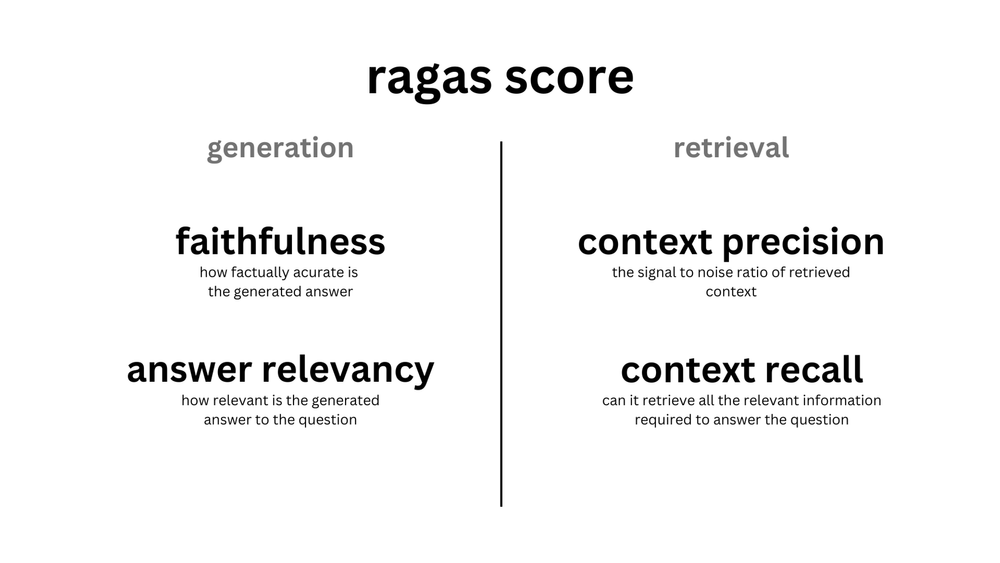

Для расчета метрик необходимы данные:

1. $Question$
- Смысл: Эта колонка содержит вопросы, на которые нужно найти ответы. В контексте задач QA, это основная информация, которую модель должна обработать для генерации ответа.
- Пример: "Каковы преимущества RAG?"

2. $Ground$_$truths$
- Смысл: В этой колонке находятся правильные ответы на соответствующие вопросы. Это может использоваться для оценки производительности модели, так как позволяет сравнить сгенерированные ответы с эталонными.
- Пример: "RAG улучшает качество генерации, используя внешние источники информации."

3. $Answer$
- Смысл: Эта колонка содержит ответы, которые генерирует модель на основе заданных вопросов. Это может быть результат работы модели, которую вы тестируете или обучаете.
- Пример: "RAG позволяет моделям извлекать информацию из внешних источников, что улучшает их способность отвечать на сложные вопросы."

4. $Contexts$
- Смысл: Эта колонка предоставляет контекст или дополнительную информацию, которая может быть полезна для понимания вопроса или для формирования ответа. Это может быть текст, из которого был извлечен ответ, или другие релевантные документы.
- Пример: "RAG (Retrieval-Augmented Generation) — это метод, который использует внешние базы данных для получения информации при генерации текста."

## Вычисление Answer Relevancy

In [ ]:
import random
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity

$Answer Relevancy$

Демонстрирует, насколько ответы соответствуют заданным вопросам. Это важный аспект, так как даже правильный ответ с технической точки зрения может быть ненужным, если он не отвечает на конкретный вопрос пользователя.

---

$\text{answer relevancy} = \frac{1}{N} \sum_{i=1}^{N} cos(E_{g_i}, E_o)$

$\text{answer relevancy} = \frac{1}{N} \sum_{i=1}^{N} \frac{E_{g_i} \cdot E_o}{\|E_{g_i}\|\|E_o\|}$

Где:

* $E_{g_i}$ - это эмбеддинг сгенерированного вопроса $i$

* $E_o$ - это эмбеддинг исходного вопроса.

* $N$ - это количество сгенерированных вопросов, которое по умолчанию равно 3.

In [ ]:
GENERATE_QUESTIONS_PROMPT = "Generate 5 questions based on answer:\n\n{}\n\nwrite only questions, no explanations required"

CHOOSE_QUESTION_PROMPT = "Choose the most relevant question to the answer:\n\n{}\n\nquestions:\n\n{}\n\nwrite only one question text from list, no explanations required"

READER_LLM = pipeline(
    model=model_llm,
    tokenizer=tokenizer_llm,
    task="text-generation",
    do_sample=True,            # Включение стохастической генерации
    temperature=0.2,           # Контроль "креативности" (ниже = более предсказуемо)
    repetition_penalty=1.1,    # Штраф за повторения (>1.0 снижает повторы)
    return_full_text=False,    # Не возвращает исходный промпт
    max_new_tokens=500,        # Лимит новых токенов на ответ
    pad_token_id=tokenizer_llm.eos_token_id
)

In [ ]:
docs_processed[:1]

In [ ]:
# Сначала создадим вопросы к 100 случайным объектам исследуемого датафрейма
# Потрубуются предобработанные тексты документов docs_processed

def data_preprocess(documents):
    """
    Принимает docs_processed, возвращает словарь processed_data {вопрос: контекст}
    """
    processed_data = {}

    for doc in tqdm(documents, desc='Обработка документов', position=0, leave=True):

        # Генерация 5 вопросов к случайному документу
        questions_prompt = GENERATE_QUESTIONS_PROMPT.format(doc.page_content)
        questions_response = READER_LLM(questions_prompt)[0]['generated_text'].strip()

        # Выбор оптимального вопроса
        choose_prompt = CHOOSE_QUESTION_PROMPT.format(doc.page_content, questions_response)
        chosen_question = READER_LLM(choose_prompt)[0]['generated_text'].strip()

        # Создание словаря {сгенерированный вопрос: контекст документа, по которому он задан}
        processed_data[chosen_question] = doc.page_content

    return processed_data

In [ ]:
def answer_relevancy(questions_n_answers:dict):
    """
    Вычисляет среднее косинусное расстояние между вопросами и ответами RAG-системы
    """
    similarity_scores = []

    for question, context in tqdm(questions_n_answers.items(),
                                  desc="Обработка вопросов",
                                  position=0,
                                  leave=True):
        # Эмбеддинг для вопроса
        question_embedding = np.array(embedding_model.embed_query(question)).reshape(1, -1)

        # Ответ, сгенерированный RAG-системой
        answer_from_rag = rag_answer(
            question=question,
            llm=READER_LLM,
            knowledge_index=KNOWLEDGE_VECTOR_DATABASE,
            reranker = RERANKER
    )[0]

        # Эмбеддинг для ответа, сгенерированного RAG
        rag_answer_embedding = np.array(embedding_model.embed_query(answer_from_rag)).reshape(1, -1)

        # Косинусная близость между вопросом и ответом
        similarity = cosine_similarity(question_embedding, rag_answer_embedding)
        similarity_scores.append(np.mean(similarity))
        tqdm.write(f"Релевантность для вопроса: {float(np.mean(similarity)):.3f}")

    return np.mean(similarity_scores)


In [ ]:
metrics = answer_relevancy(data_preprocess(random.sample(docs_processed, 100)))

In [ ]:
print('Answer relevancy на 100 случайных документах датасета:', round(float(metrics),2))

**Вывод**: на 100 примерах вопросов и сгенерированных RAG-системой ответах значение RAGAS метрики **answer relevancy** составляет $0.89$

# Отчёт о создании RAG-cистемы

#### **1. Произведена предобработка данных**
▸ Для очистки датасета использована комбинация фильтров по тектовому описанию и по изображениям, к которым составлены описания

▸ Наблюдается зависимость между наличием изображения, не относящемся к туристической тематике, и низким tf-idf слова в описании данного

▸ На основании наблюдаемого факта из датасета исключены объекты выбросы

▸ Также исключены объекты с отсутствующим полностью описанием или id Wikidata

▸ Объекты сгруппированы так, чтобы один объект описывал, по возможности, одну достопримечательность.
▸ Тексты описания объединены, при помощи BLEU повышена уникальность предложений в объединенных описаниях

#### **2. Построена RAG-система**
▸ Модель эмбеддингов = `intfloat/multilingual-e5-large`

▸ Основная языковая модель = `teknium/OpenHermes-2.5-Mistral-7B` квантизованная

▸ Векторная база данных = `FAISS`

▸ Реранкер = `colbert-ir/colbertv2.0`

#### **3. Построена PCA и UMAP визуализация эмбеддингов базы данных в 2D-пространстве**
Отчетливо наблюдаются кластеры, образованные городами: Владимир, Ярославль, Нижний Новгород, Екатеринбург.

#### **4. Проверена функциональность RAG-системы**
RAG-система функционирует.
Приведен обзор метрик оценки RAG-системы:
▸ Faithfullness

▸ Answer Relevancy

▸ Context Recall

▸ Context Precision

▸ Answer Semantic Similarity

▸ Answer Correctness.

#### **5. Качество RAG протестировано**
В соответствии с документацией RAGAS cоздана функция для проверки качества Answer Relevancy. Качество усреднено по 100 случайным парам вопрос-ответ и составляет **0.89**.